In [162]:
%load_ext autoreload

%matplotlib inline
%autoreload 2

# Supress nosiy deprecation warning from inside matplotlib
import warnings
warnings.filterwarnings('ignore')

import pandas
import matplotlib
import matplotlib.pyplot as plt
import folium
import math

import oslo

matplotlib.rcParams['figure.figsize'] = (10, 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Download raw data
start = (2016, 6)
end = (2017, 8)
notexisting = [(2017, 1), (2017, 2), (2017, 3) ]
periods = sorted(set(oslo.months_between(start, end)).difference(notexisting))
for period in periods:
    try:
        filename = oslo.download_trip(*period)
    except Exception as e:
        raise RuntimeError("Could not download %d-%d: %s" % (*period, e.msg))
"done"

skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.6.1-2016.6.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.7.1-2016.7.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.8.1-2016.8.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.9.1-2016.9.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.10.1-2016.10.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.11.1-2016.11.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2016.12.1-2016.12.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.4.1-2017.4.30.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.5.1-2017.5.31.csv.zip
skipping existing http://oslo-citybike.s3.amazonaws.com/exports/trips-2017.6.1-2017.6.30.csv.zip
skipping existing http:/

'done'

In [55]:
stations = oslo.read_stations()
print("%d stations" % len(stations.keys()))
dict(filter(lambda kv: kv[0] != 'bounds', stations[157].items()))

153 stations


{'center': {'latitude': 59.91562, 'longitude': 10.762248},
 'id': 157,
 'in_service': True,
 'number_of_locks': 30,
 'subtitle': 'mellom Norbygata og Urtegata',
 'title': 'Nylandsveien'}

In [12]:
map_center = [59.925, 10.75]
map_zoom = 12
station_map = folium.Map(location=map_center, zoom_start=map_zoom)

for _, station in stations.items():
    center = station['center']
    lon, lat = center['longitude'], center['latitude']
    folium.CircleMarker([lat, lon],
                radius=1, popup=station['title'],
                color='#dd0000', fill_color='#dd0000',
    ).add_to(station_map)
    
station_map

In [56]:
# Read in the files
# NOTE: Full set uses about 700MB of RAM, and 1 minutes to load
trips = pandas.DataFrame()
for period in periods[:1]:
    filename = "data/"+ oslo.trips_basename(*period)+'.csv'
    print('reading', filename)
    frame = pandas.read_csv(filename, index_col=None, header=0, parse_dates=[1, 3])
    trips = pandas.concat([trips, frame])
trips[:3]

reading data/trips-2016.6.1-2016.6.30.csv


,Start station,Start time,End station,End time
0,226,2016-06-01 03:59:59,243,2016-06-01 04:02:14
1,206,2016-06-01 04:00:02,212,2016-06-01 04:18:46
2,290,2016-06-01 04:00:06,261,2016-06-01 04:02:14


In [6]:
number_trips = trips.shape[0]
number_trips

377677

In [69]:
trips.set_index(['Start time'], drop=False, inplace=True)
first = trips['Start time'].min()
last = trips['Start time'].max()
first, last

(Timestamp('2016-06-01 03:59:59'), Timestamp('2016-06-30 21:59:53'))

In [13]:
len(trips['End station'].unique())

133

   ## Enriching the data

In [61]:
# Add trip durations intervals
trips['Duration'] = trips['End time'] - trips['Start time']
# Convert from nanoseconds, remove timedelta type
trips['Duration Seconds'] = pandas.Series(trips['Duration'], dtype='int64').abs() / (1000*1000*1000)

In [62]:
# Add distance of the trip
# Note: a bit slow, since doing geometric calculations in pure Python
subs = trips
subs['Distance'] = subs.apply(lambda r: oslo.calculate_distance(stations, r), 'columns')

In [17]:
# Add overall velocity (m/s)
trips['Velocity'] = trips['Distance'] / trips['Duration Seconds'] 
trips[:3]

,Start station,Start time,End station,End time,Duration,Duration Seconds,Distance,Velocity
Start time,,,,,,,,
2016-09-01 04:00:02,291,2016-09-01 04:00:02,301.0,2016-09-01 04:06:06,00:06:04,364.0,1680.530949,4.616843
2016-09-01 04:00:07,262,2016-09-01 04:00:07,292.0,2016-09-01 04:15:43,00:15:36,936.0,2861.080251,3.056710
2016-09-01 04:00:07,277,2016-09-01 04:00:07,163.0,2016-09-01 04:03:07,00:03:00,180.0,513.889305,2.854941


## Cleaning the data

In [63]:
### Do people return to same station often?
import numpy
self_ = trips[trips['Start station'].eq(trips['End station'])]
len(self_)/len(trips)*100
# About 5-10% of the trips go back to same stations

7.850784462644798

In [19]:
# 30% of return-to-same trips are below 1 minute.
# Where as < 3% of all trips are below. Probably errors!
minimum_duration = 1*60
own_trips = trips[trips['Start station'] == (trips['End station'])]
veryshort = trips[trips['Duration Seconds'] < minimum_duration]
invalid = own_trips[own_trips['Duration Seconds'] < minimum_duration] 

possibly_valid = (len(veryshort)-len(invalid))/len(trips)
print("""
Eliminating trips under %d sec.
%.3f%% of start!=end trips
%d start==trips""" % (minimum_duration, 100*possibly_valid, len(invalid)))


Eliminating trips under 60 sec.
0.055% of start!=end trips
8183 start==trips


In [64]:
# Eliminating
valid = trips['Duration Seconds'] > minimum_duration
trips = trips[valid]
len(trips)

284379

In [65]:
# Trips with missing start/end stations
missing_start = trips[pandas.isnull(trips['Start station'])]
missing_end = trips[pandas.isnull(trips['End station'])]
len(missing_start + missing_end)

0

In [66]:
# Find missing station info
def not_nan(n):
    return not math.isnan(n)
known_stations = set(stations.keys())
start_stations = set(filter(not_nan, trips['Start station'].unique()))
end_stations =  set(filter(not_nan, trips['End station'].unique()))
trip_stations = start_stations | end_stations
unknown_stations = trip_stations - known_stations
print(unknown_stations)

len(trips[trips['End station'].isin(unknown_stations)]), len(trips[trips['Start station'].isin(unknown_stations)])

{288, 172, 173, 271, 186}


(10500, 9403)

## Basic characteristics

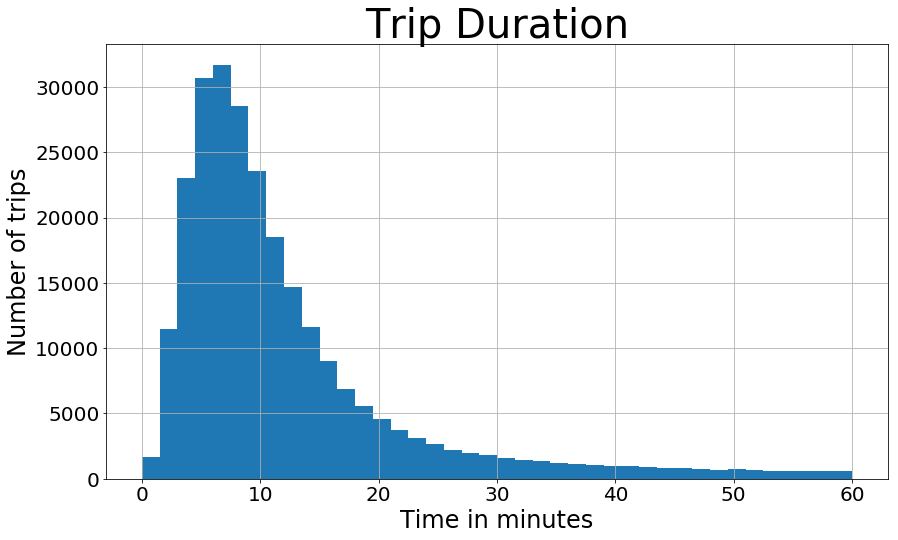

In [67]:
percentile_lim = 0.75
duration_mean = trips['Duration Seconds'].median() / 60
percentile = trips['Duration Seconds'].quantile(percentile_lim) / 60 
(trips['Duration Seconds'] / 60).hist(bins=40, range=(0, 60), xlabelsize=20, ylabelsize=20)
#plt.text(30.1, 20500, 'Median: %.2f' % (duration_mean), fontsize=30)
#plt.text(30.1, 15500, '%d %% percentile: %.2f' % (percentile_lim*100 ,percentile), fontsize=30)
plt.xlabel('Time in minutes', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Trip Duration', fontsize=40)
plt.savefig('Trip Duration.png', format='png', dpi=300)

In [24]:
trips['Duration Seconds'].max()/(3600*24)

40.802488425925922

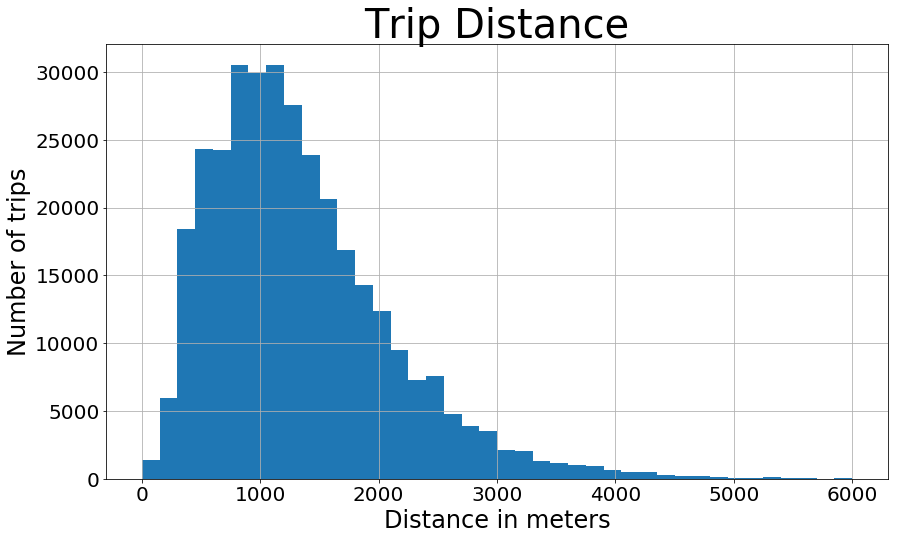

In [25]:
# 0 is a very common distance (travel back to self), ignore it
trips['Distance'].hist(bins=40, range=(1, 6000), xlabelsize=20, ylabelsize=20)
plt.xlabel('Distance in meters', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Trip Distance', fontsize=40)
plt.savefig('Trip Distance.png', format='png', dpi=300)

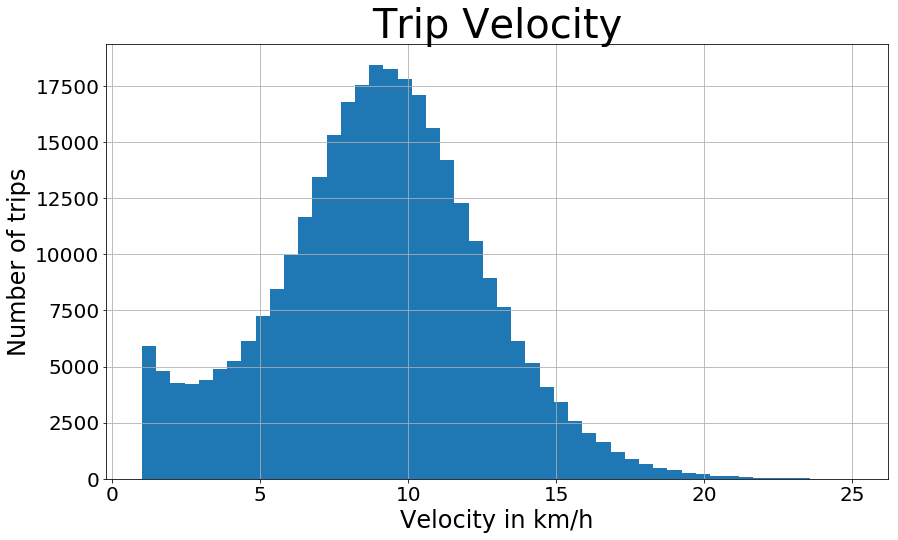

In [26]:
(trips['Velocity'] * 3.6).hist(bins=50, range=(1,25), xlabelsize=20, ylabelsize=20)
plt.xlabel('Velocity in km/h', fontsize=24)
plt.ylabel('Number of trips', fontsize=24)
plt.title('Trip Velocity', fontsize=40)
plt.savefig('Trip Velocity.png', format='png', dpi=300)

<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

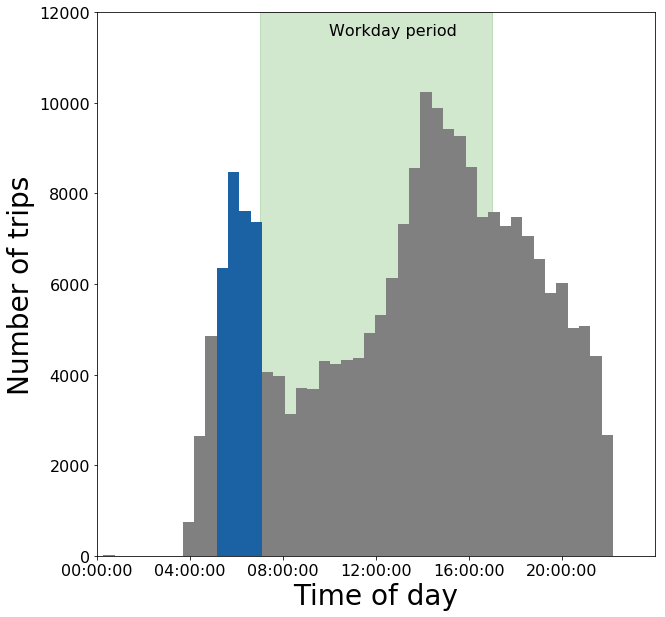

In [163]:
def plot_trip_times(series, title=None, selected=None, ymax=12000):
    # Plot distribution of trips over the day
    _, bins, patches = plt.hist(series.dropna().values, bins=48, zorder=1)
    plt.xticks(range(0, 24*3600, 4*3600))
    
    axs = plt.gca()
    axs.set_ylim([0, ymax])
    axs.set_xlim([0, 24*3600])
    axs.tick_params(axis='both', labelsize=16)

    # Show a typical workday
    workday = (7*3600, 17*3600)
    workday_color = '#19880d'
    axs.axvspan(xmin=workday[0], xmax=workday[1], alpha=0.2, color=workday_color, zorder=0)
    plt.text(s='Workday period', x=(10*3600), y=ymax-500, fontsize=16)
    
    # Colorize selected part of data
    selected_color = '#1b62a5'
    unselected_color = 'grey'
    for patch, start in zip(patches, bins):
        s = True if selected is None else (start > selected[0] and start < selected[1])
        c = selected_color if s else unselected_color
        patch.set_facecolor(c)

    plt.xlabel('Time of day', fontsize=28)
    plt.ylabel('Number of trips', fontsize=28)
    plt.savefig('%s.png' % title, format='png', dpi=300)
    return plt

to_work = (5*3600, 7*3600)
timeofday = trips
timeofday['timeofday'] = trips.index.time
series = timeofday['timeofday']
plot_trip_times(series[trips.index.weekday < 5], title='towork-trips', selected=to_work)

<module 'matplotlib.pyplot' from '/usr/lib/python3.6/site-packages/matplotlib/pyplot.py'>

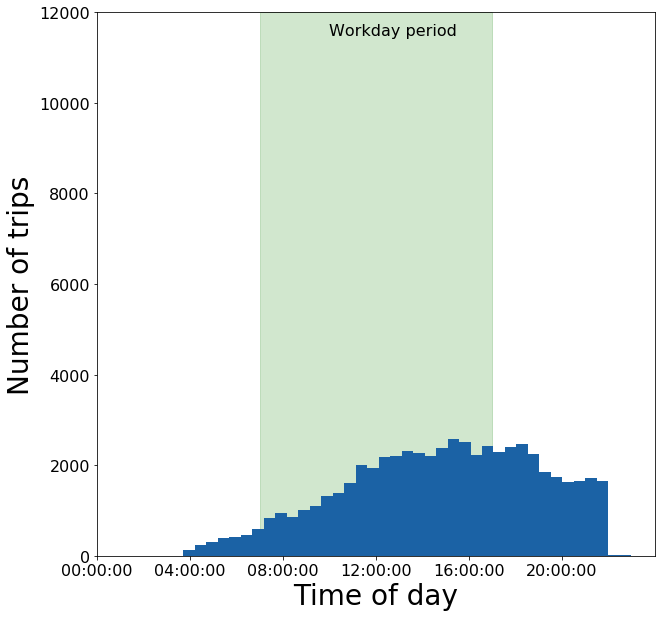

In [164]:
plot_trip_times(series[trips.index.weekday >= 5], title='weekend-trips')

## Station connectivity

In [32]:
# How are stations connected to eachother?
period = trips
cross = pandas.crosstab(period['Start station'], period['End station'])
relative = cross.div(cross.sum(axis=1), axis=0)
relative[:3]

End station,157.0,158.0,159.0,160.0,161.0,162.0,163.0,164.0,167.0,169.0,...,299.0,301.0,302.0,304.0,305.0,306.0,307.0,308.0,309.0,310.0
Start station,,,,,,,,,,,,,,,,,,,,,
157,0.051030,0.000000,0.001537,0.005533,0.000000,0.003074,0.030126,0.017830,0.003381,0.002459,...,0.000922,0.006763,0.011067,0.000615,0.000000,0.007685,0.000000,0.0,0.000000,0.000307
158,0.002801,0.064426,0.005602,0.000000,0.002801,0.025210,0.008403,0.005602,0.000000,0.000000,...,0.005602,0.002801,0.000000,0.000000,0.000000,0.008403,0.000000,0.0,0.005602,0.000000
159,0.008207,0.000000,0.055292,0.001728,0.004320,0.019438,0.008639,0.012959,0.000864,0.003456,...,0.002160,0.002160,0.003024,0.001728,0.000432,0.005184,0.000864,0.0,0.002592,0.000432


In [33]:
df = trips
df = df[df.index.weekday >= 5]
clustered = oslo.cluster_connected(df, n_clusters=6)
#print([len(c) for c in clustered])
oslo.plot_station_groups(stations, clustered)

In [34]:
df = trips[trips.index.weekday < 5 ]
#df = df.between_time('10:00', '12:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

In [119]:
df = trips[trips.index.weekday < 5 ]
df = df.between_time('5:00', '7:00')
clustered = oslo.cluster_connected(df, n_clusters=6)
oslo.plot_station_groups(stations, clustered)

In [36]:
stats = oslo.cluster_stats(stations, trips, clustered)
# TODO: sanity check clustering
stats

,0,1,2,3,4,5
0,82371.0,35933.0,6349.0,12389.0,7140.0,1182.0
1,49367.0,77356.0,8293.0,2949.0,3444.0,600.0
2,10376.0,9792.0,7028.0,1172.0,2160.0,1577.0
3,10906.0,2153.0,609.0,6323.0,1598.0,83.0
4,10128.0,4270.0,2037.0,2939.0,3992.0,366.0
5,1453.0,902.0,1433.0,138.0,302.0,69.0


In [ ]:
# Visualize clustered connectivity
dot = oslo.cluster_digraph(clustered, stats)

#dot    

In [120]:
df = (trips[trips.index.weekday < 5 ]).between_time('5:00', '7:00')
clustered, centers, st = oslo.cluster_connected(df, n_clusters=6, method='affinitypropagation')
center_stations = list(map(lambda idx: st.values[idx], centers))
m = oslo.plot_station_groups(stations, clustered, center_stations)
m.save('affinity-cluster-workday-commute.html')
m

In [41]:
df = (trips[trips.index.weekday >= 5 ])
clustered, centers, st = oslo.cluster_connected(df, n_clusters=6, method='affinitypropagation')
center_stations = list(map(lambda idx: st.values[idx], centers))
m = oslo.plot_station_groups(stations, clustered, center_stations)
m.save('affinity-cluster-weekend.html')
m